In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 35.46 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
def file_data(filepath):
  with open(filepath) as f:
    return f.readlines()

In [ ]:
dataset_directory = "pubmed-rct/PubMed_20k_RCT/"

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# reading data from directory and storing in another directory
training_dir = file_data(dataset_directory + 'train.txt')

In [ ]:
training_dir[13].isspace()

True

In [ ]:
learning_sample = training_dir[:100]

In [ ]:
learning_sample[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [ ]:
def get_data(path):
    raw_data = file_data(path)
    article_data = ''
    data_sample = []
    article_id = 0

    for line in raw_data:
        if line.startswith('###'):
            article_id = int(line.replace('###', '').replace('\n', '')) # getting the ID of the blog
            article_data = ''

        elif line.isspace(): # end of one article
            article_data_split = article_data.splitlines()

            for article_line_number, article_line in enumerate(article_data_split):
                line_data = {} # storing in dictionary
                target_text_split = article_line.split("\t") # split target label from text

                line_data["article_id"] = article_id # storing artice ID
                line_data["line_id"] = f'{article_id}_{article_line_number}_{len(article_data_split)}' # create id for each line from the artice
                line_data["abstract_text"] = target_text_split[1] # storing target text
                line_data["line_number"] = article_line_number # get line number in the article
                line_data["total_lines"] = len(article_data_split) # total number of lines in article
                line_data['current_line'] = f'{article_line_number}_{len(article_data_split)}' # embedding article lenghth with line number
                line_data["target"] = target_text_split[0] # storing the label of the target

                data_sample.append(line_data) # appending the sample data

        else: #line into article line if the condition is not satisfied.
            article_data += line

    return data_sample

In [ ]:
train_samples = get_data(dataset_directory + "train.txt")
val_samples = get_data(dataset_directory + "dev.txt")
test_samples = get_data(dataset_directory + "test.txt")

In [ ]:
train_samples

[{'article_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'article_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'article_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  

In [ ]:
# length of the samples
print('1. lenth of the train samples after processing: ',len(train_samples))
print('2. lenth of the test samples after processing: ',len(test_samples))
print('3. lenth of the val samples after processing: ',len(val_samples))

1. lenth of the train samples after processing:  180040
2. lenth of the test samples after processing:  30135
3. lenth of the val samples after processing:  30212


In [ ]:
train_datafram = pd.DataFrame(train_samples)
val_dataframe = pd.DataFrame(val_samples)
test_dataframe = pd.DataFrame(test_samples)

In [ ]:
train_datafram['target'].value_counts().sort_values()

OBJECTIVE      13839
BACKGROUND     21727
CONCLUSIONS    27168
RESULTS        57953
METHODS        59353
Name: target, dtype: int64

In [ ]:
train_datafram['target'].value_counts().values

array([59353, 57953, 27168, 21727, 13839])

In [ ]:
train_dist = train_datafram['target'].value_counts().sort_values()
val_dist = val_dataframe['target'].value_counts().sort_values()
test_dis = test_dataframe['target'].value_counts().sort_values()

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


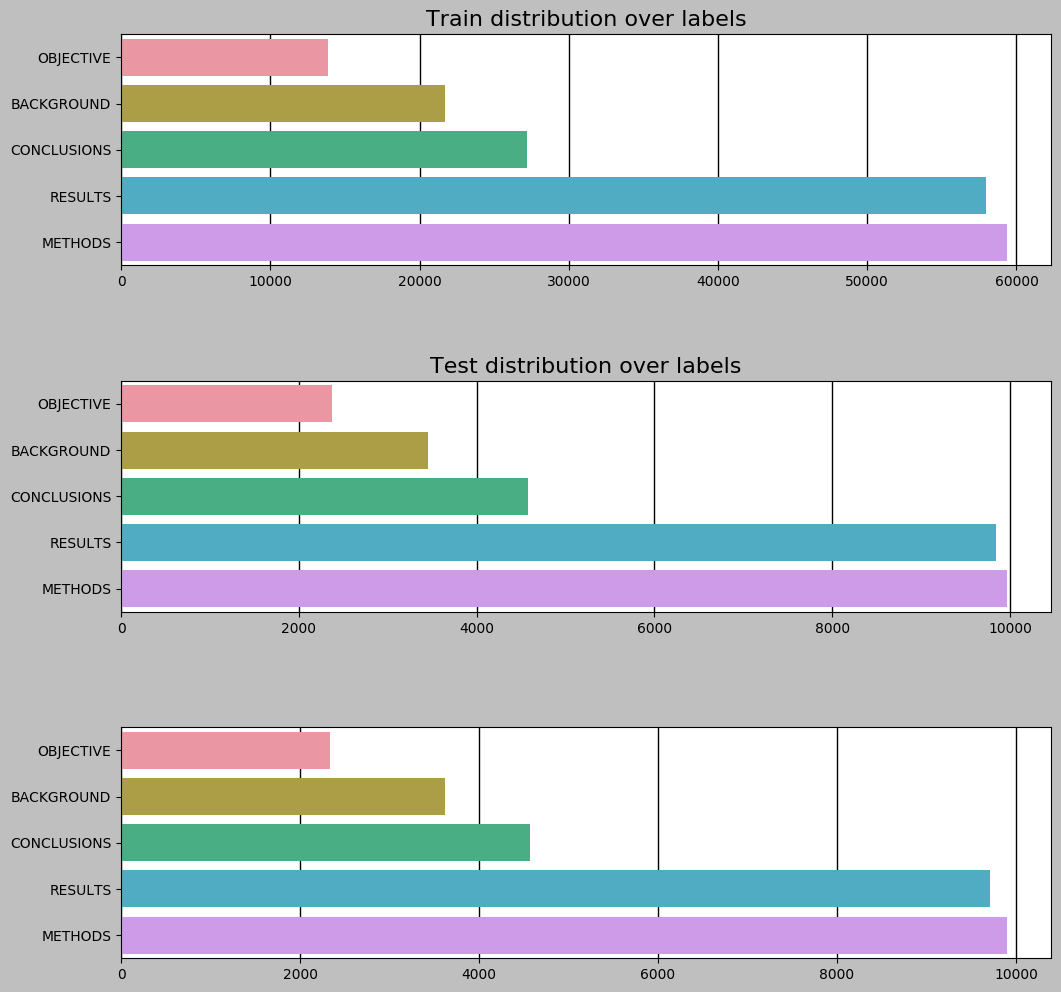

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
#lt.style.use('grayscale')
sns.barplot(x=train_dist.values, y=list(train_dist.index), ax=ax[0],orient='h')
ax[0].set_title('Train distribution over labels')

sns.barplot(x=val_dist.values, y=list(val_dist.index), ax=ax[1],orient='h')
ax[1].set_title('validation distribution over labels')

sns.barplot(x=test_dis.values, y=list(test_dis.index), ax=ax[2],orient='h')
ax[1].set_title('Test distribution over labels')
plt.subplots_adjust(hspace=0.5)

plt.show()


In [ ]:
ohc = OneHotEncoder(sparse=False)

In [ ]:
train_labels_one_hot_encoded = ohc.fit_transform(train_datafram["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot_encoded = ohc.transform(val_dataframe["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot_encoded = ohc.transform(test_dataframe["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
LE = LabelEncoder()

In [ ]:
train_lables_encoded = LE.fit_transform(train_datafram["target"].to_numpy())

In [ ]:
val_lables_encoded = LE.transform(val_dataframe["target"].to_numpy())
test_lables_encoded = LE.transform(test_dataframe["target"].to_numpy())

In [ ]:
train_lables_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# number of classes
print('Number of classes: ',len(LE.classes_))
print('All the Classes :', LE.classes_)

Number of classes:  5
All the Classes : ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [ ]:
ohc_for_lines = OneHotEncoder(sparse=False)

In [ ]:
train_lines_encoded = ohc_for_lines.fit_transform(train_datafram["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = ohc_for_lines.transform(val_dataframe["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = ohc_for_lines.transform(test_dataframe["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth

    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0

    return unsmooth

In [ ]:
# applying smoothing on train lines
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [ ]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:

    AUTOTUNE = tf.data.AUTOTUNE
    ds = tf.data.Dataset.from_tensor_slices((features, labels))

    # shuffling on the basis of condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        #batches
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_sentence_list = train_datafram["abstract_text"].tolist()
val_sentence_list = val_dataframe["abstract_text"].tolist()
test_sentence_list = test_dataframe["abstract_text"].tolist()

In [ ]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentence_list, train_lines_encoded.astype(np.float32))
train_labels = train_labels_one_hot_encoded.astype(np.float32)

# creating pipeline
train_ds = create_pipeline(
    train_features, train_labels,
    batch_size=BATCH_SIZE, shuffle=True,
    cache=False, prefetch=True)

In [ ]:
# applying the same to val_data
val_features = (val_sentence_list, val_lines_encoded.astype(np.float32))
val_labels = val_labels_one_hot_encoded.astype(np.float32)

val_ds = create_pipeline(val_features, val_labels,
                         batch_size=BATCH_SIZE, shuffle=False,
                         cache=False, prefetch=True)

In [ ]:
# applying to test data
test_features = (test_sentence_list, test_lines_encoded.astype(np.float32))
test_labels = test_labels_one_hot_encoded.astype(np.float32)

test_ds = create_pipeline(test_features, test_labels,
                          batch_size=BATCH_SIZE, shuffle=False,
                          cache=False, prefetch=True)

In [ ]:
# eetting model/processor from hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [ ]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [ ]:
class SelfAttentionBlock(layers.Layer):

    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)

        self.query = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer,
                                 return_sequences=True, name=f'block_query_lstm')

        self.value = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer, go_backwards=True,
                                 return_sequences=True, name=f'block_value_lstm')

        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')


    def __call__(self, x):
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)

        #LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)

        #self-attention to LSTM
        block_attention = self.attention([block_query, block_value])

        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)

        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)

        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])

        return block_residual

In [ ]:
def build_model():
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')

    initializer = tf.keras.initializers.GlorotNormal()

    abstract_embedding = encoder(abstract_input)
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)


    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input,
                                  abstract_current_line],
                          outputs=[output_layer], name="use_attention_model")

In [ ]:
model = build_model()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 abstract_text_input (Input  [(None,)]                    0         []                            
 Layer)                                                                                           
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['abstract_text_input[0][0]'] 
  (KerasLayer)                                            24                                      
                                                                                                  
 block_dim_expand (Lambda)   (None, 1, 512)               0         ['universal_sentence_encoder[0
                                                                    ][0]']      

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]

In [ ]:
train_sentences_count = len(train_sentence_list)
val_sentences_count = len(val_sentence_list)
test_sentences_count = len(test_sentence_list)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

In [ ]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10
5627/5627 [==============================] - 145s 24ms/step - loss: 0.6963 - accuracy: 0.8476 - val_loss: 0.6421 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - 129s 23ms/step - loss: 0.6315 - accuracy: 0.8794 - val_loss: 0.6390 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - 142s 25ms/step - loss: 0.6140 - accuracy: 0.8878 - val_loss: 0.6339 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 4/10
5627/5627 [==============================] - 131s 23ms/step - loss: 0.6014 - accuracy: 0.8938 - val_loss: 0.6358 - val_accuracy: 0.8755 - lr: 0.0010
Epoch 5/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.8999
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 [==============================] - 139s 25ms/step - loss: 

In [ ]:
model.evaluate(test_ds)

942/942 [==============================] - 16s 16ms/step - loss: 0.6438 - accuracy: 0.8715


[0.6438229084014893, 0.8715115189552307]

In [ ]:
val_prob = model.predict(val_ds, verbose=1)
val_predictions = tf.argmax(val_prob, axis=1)

945/945 [==============================] - 14s 14ms/step


In [ ]:
test_prob = model.predict(test_ds, verbose=1)
test_predict = tf.argmax(test_prob, axis=1)

942/942 [==============================] - 18s 19ms/step


In [ ]:
print(val_predictions)
print(test_predict)

tf.Tensor([0 0 3 ... 4 1 1], shape=(30212,), dtype=int64)
tf.Tensor([0 2 2 ... 4 4 1], shape=(30135,), dtype=int64)


In [ ]:
LE.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
class_labels = LE.classes_

In [ ]:
# Generate validation classification report
print(classification_report(val_lables_encoded, val_predictions, target_names=class_labels))

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.82      0.76      3449
 CONCLUSIONS       0.89      0.93      0.91      4582
     METHODS       0.92      0.91      0.92      9964
   OBJECTIVE       0.71      0.58      0.64      2376
     RESULTS       0.92      0.90      0.91      9841

    accuracy                           0.87     30212
   macro avg       0.83      0.83      0.83     30212
weighted avg       0.88      0.87      0.87     30212



In [ ]:
# Generate test classification report
print(classification_report(test_lables_encoded, test_predict, target_names=class_labels))

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.81      0.76      3621
 CONCLUSIONS       0.89      0.93      0.91      4571
     METHODS       0.91      0.92      0.92      9897
   OBJECTIVE       0.69      0.59      0.63      2333
     RESULTS       0.92      0.89      0.90      9713

    accuracy                           0.87     30135
   macro avg       0.83      0.83      0.83     30135
weighted avg       0.87      0.87      0.87     30135



In [ ]:
from sklearn.metrics import accuracy_score,top_k_accuracy_score, precision_recall_fscore_support,matthews_corrcoef
def performance_metrics(y_actual, y_predicted, y_probabilities):

    model_accuracy = round(accuracy_score(y_actual, y_predicted), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_actual, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_lables_encoded,
                                                                                 test_predict,
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_actual, y_predicted), 5)

    print(f'\nPerformance Metrics:\n')
    print('----------------**-------------------')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('*********************************')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('*********************************')
    print(f'precision_score:\t{model_precision}\n')
    print('*********************************')
    print(f'recall_score:\t\t{model_recall}\n')
    print('*********************************')
    print(f'f1_score:\t\t{model_f1}\n')
    print('*********************************')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')

    return

In [ ]:
performance_metrics(val_lables_encoded,val_predictions,val_prob)


Performance Metrics:

----------------**-------------------
accuracy_score:		0.87452

*********************************
top_3_accuracy_score:	0.99533

*********************************
precision_score:	0.87183

*********************************
recall_score:		0.87151

*********************************
f1_score:		0.87094

*********************************
matthews_corrcoef:	0.83177



In [ ]:
performance_metrics(test_lables_encoded,test_predict,test_prob)


Performance Metrics:

----------------**-------------------
accuracy_score:		0.87151

*********************************
top_3_accuracy_score:	0.99363

*********************************
precision_score:	0.87183

*********************************
recall_score:		0.87151

*********************************
f1_score:		0.87094

*********************************
matthews_corrcoef:	0.82805



In [ ]:
cm = confusion_matrix(test_lables_encoded,test_predict)

<Axes: >

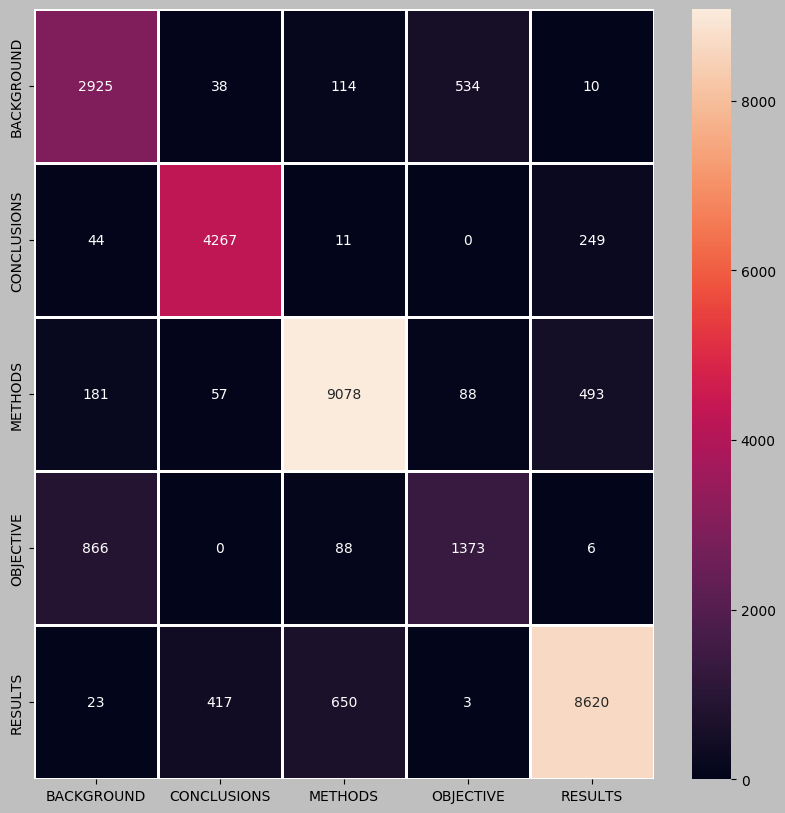

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidths=1,xticklabels=class_labels,yticklabels=class_labels,fmt='d')

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython as ipd
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout

In [ ]:
# directory path of mounted gdrive
bas_dir_path = r'/content/drive/MyDrive/edge-collected-gunshot-audio.zip'

In [ ]:
#creating directory for the extracted data
os.makedirs(os.path.join(os.getcwd(),'extracted_data'))

In [ ]:
# unzipping all the files into to extracted_data created directory
import zipfile
with zipfile.ZipFile(bas_dir_path,'r') as zip_ref:
  zip_ref.extractall(os.path.join(bas_dir_path,'/content/extracted_data'))

In [ ]:
!pip install split-folders

In [ ]:
os.makedirs(os.path.join(os.getcwd(),'my_split_data')) # directory for storing the splitted data

In [ ]:
# splitting the data into 80:20 ratio
import splitfolders
splitfolders.ratio('/content/extracted_data/edge-collected-gunshot-audio','/content/my_split_data',seed=42,ratio=(0.8,0.2))

Copying files: 2148 files [00:11, 180.55 files/s]


In [ ]:
train_dir_path = r'/content/my_split_data/train' # newly created train directory which contains 80% of the files
val_dir_path = r'/content/my_split_data/val' # newly created validation directory which contains 20% of tha files

In [ ]:
# creating function for extracting features of the given .wav files
def extract_features(filename):
  audio, sr = librosa.load(filename,sr = None,res_type='kaiser_fast')
  mfccs = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=40)
  mfcc_scaled = np.mean(mfccs.T,axis=0)
  return mfcc_scaled

In [ ]:
# checking for sample_rate
ex_data, sampling_rate = librosa.load('/content/extracted_data/edge-collected-gunshot-audio/38s&ws_dot38_caliber/03fc4685-909e-42c5-aff0-f519f1d14b12_chan0_v0.wav', sr=None,res_type='kaiser_fast')
print(sampling_rate)

44100


In [ ]:
!pip install resampy # internally res_type='kaiser_fast' calling resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.1 MB/s eta 0:00:00


In [ ]:
features=[] # collecting the features and labels for the .wav files
firearm = ''
for folder in os.listdir('/content/my_split_data/train'):
  gen = glob.iglob('**/*.wav',root_dir=os.path.join('/content/my_split_data/train',folder),recursive=True) # using iglob generator for extracting the files.
  for files in gen:
    path = os.path.join(os.path.join('/content/my_split_data/train',folder),files) # path to provide for extract_features fucntion.
    data = extract_features(path) # calling extract_features functions for loading features
    firearm = folder # assigning the name of the firearm as label
    features.append([data,firearm]) # appending the extracted features and labels

In [ ]:
#df = pd.DataFrame()
df = pd.DataFrame(features,columns=['feature','class']) # converting into dataframe for the extracted features and labels
df.head()

,feature,class
0,"[-479.21558, 115.43387, 4.464393, -2.232155, 0...",remington_870_12_gauge
1,"[-622.7922, 160.48073, -31.198713, -13.155003,...",remington_870_12_gauge
2,"[-685.34485, 205.09016, -12.939822, -16.207764...",remington_870_12_gauge
3,"[-244.56116, 180.25233, -31.406918, 10.96077, ...",remington_870_12_gauge
4,"[-683.1073, 138.53195, 10.358094, -3.0826027, ...",remington_870_12_gauge


In [ ]:
X_copy = df['feature'].copy()  # copying the data from the above dataframe for nor editing the original data.
y_copy = df['class'].copy() # copying the labels correpondingly.

In [ ]:
X = np.array(X_copy.to_list()) # into list
y = np.array(y_copy.to_list())

In [ ]:
X = np.array(X_copy.to_list()) # converting into array
y = np.array(y_copy.to_list())
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
LE = LabelEncoder()
yy = to_categorical(LE.fit_transform(y)) # fitting and transforming on training data of labels and converting into to_categorical
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,yy, test_size=0.2, random_state=42) # splitting into train and test

In [ ]:
#validation data
val_features=[] # applying fucntion on validation data and storing in list.
val_labels = ''
for folder in os.listdir('/content/my_split_data/val'):
  gen = glob.iglob('**/*.wav',root_dir=os.path.join('/content/my_split_data/val',folder),recursive=True)
  for files in gen:
    path = os.path.join(os.path.join('/content/my_split_data/val',folder),files)
    value = extract_features(path)
    val_labels = folder
    val_features.append([value,val_labels])

In [ ]:
# total number of files in validation data
len(os.listdir('/content/my_split_data/val/38s&ws_dot38_caliber')) + len(os.listdir('/content/my_split_data/val/glock_17_9mm_caliber')) + len(os.listdir('/content/my_split_data/val/remington_870_12_gauge')) + len(os.listdir('/content/my_split_data/val/ruger_ar_556_dot223_caliber'))

431

In [ ]:
val_df = pd.DataFrame(val_features,columns=['val_features','val_labels']) # into DataFrame

In [ ]:
val_df.shape # verifying the shape of the data

(431, 2)

In [ ]:
x_val_copy = val_df['val_features'].copy() # creating copies of original data
y_val_copy = val_df['val_labels'].copy()
x_val_array = np.array(x_val_copy.to_list()) # into list
y_val_array = np.array(y_val_copy.to_list())

In [ ]:
y_val_array_encoded = to_categorical(LE.fit_transform(y_val_array)) # transforming with the help of 'LE' and convering into to_categorical

In [ ]:
num_rows = 4
num_columns = 10
num_channels = 1
num_labels = yy.shape[1]
filter_size = 2
x_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels) # reshaping the training and validation data for feeding into CNN model
x_val = x_val_array.reshape(x_val_array.shape[0], num_rows, num_columns, num_channels)

In [ ]:
# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 4, 10, 16)         80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 10, 16)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 10, 16)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 10, 32)         2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 10, 32)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 4, 10, 32)        

In [ ]:
num_epochs = 50
num_batch_size = 50
# fitting the model
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val_array_encoded), verbose=1)

Epoch 1/50
28/28 [==============================] - 4s 68ms/step - loss: 0.5877 - accuracy: 0.2935 - val_loss: 0.5705 - val_accuracy: 0.3109
Epoch 2/50
28/28 [==============================] - 2s 54ms/step - loss: 0.5601 - accuracy: 0.3081 - val_loss: 0.5588 - val_accuracy: 0.3248
Epoch 3/50
28/28 [==============================] - 1s 35ms/step - loss: 0.5561 - accuracy: 0.3248 - val_loss: 0.5538 - val_accuracy: 0.3689
Epoch 4/50
28/28 [==============================] - 1s 34ms/step - loss: 0.5531 - accuracy: 0.3372 - val_loss: 0.5491 - val_accuracy: 0.3503
Epoch 5/50
28/28 [==============================] - 1s 33ms/step - loss: 0.5478 - accuracy: 0.3540 - val_loss: 0.5449 - val_accuracy: 0.3852
Epoch 6/50
28/28 [==============================] - 1s 33ms/step - loss: 0.5407 - accuracy: 0.4020 - val_loss: 0.5401 - val_accuracy: 0.4524
Epoch 7/50
28/28 [==============================] - 1s 33ms/step - loss: 0.5420 - accuracy: 0.3889 - val_loss: 0.5352 - val_accuracy: 0.4316
Epoch 8/50
28

In [ ]:
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels) # converting test_data for predictions

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.math import confusion_matrix
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Print the evaluation metrics
print(f'Accuracy - CNN: {accuracy}')
print(f'Precision - CNN: {precision}')
print(f'Recall - CNN: {recall}')
print(f'F1 Score - CNN: {f1}')

print('Confusion_matrix - CNN: ',confusion_matrix(y_test_classes, y_pred_classes))

11/11 [==============================] - 0s 22ms/step
Accuracy - CNN: 0.6133720930232558
Precision - CNN: 0.6331407042803696
Recall - CNN: 0.6133720930232558
F1 Score - CNN: 0.5888214198046698
Confusion_matrix - CNN:  tf.Tensor(
[[35 12  3 22]
 [14 73  1 24]
 [10 18 14 19]
 [ 2  7  1 89]], shape=(4, 4), dtype=int32)


In [ ]:
from tensorflow.keras.layers import LSTM, Dense,Dropout,Flatten
from tensorflow import keras
# Build a simple LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(128, input_shape=(X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(len(LE.classes_), activation='softmax'))

# Compile the model
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape features for LSTM input
x_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
x_val = x_val_array.reshape((x_val_array.shape[0], x_val_array.shape[1], 1))
x_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
model_LSTM.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val_array_encoded), verbose=1)

# Evaluate the model
loss, accuracy = model_LSTM.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/50
43/43 [==============================] - 8s 74ms/step - loss: 1.3604 - accuracy: 0.3132 - val_loss: 1.3335 - val_accuracy: 0.3480
Epoch 2/50
43/43 [==============================] - 4s 85ms/step - loss: 1.3104 - accuracy: 0.3846 - val_loss: 1.2868 - val_accuracy: 0.3759
Epoch 3/50
43/43 [==============================] - 4s 102ms/step - loss: 1.2635 - accuracy: 0.4246 - val_loss: 1.2519 - val_accuracy: 0.4362
Epoch 4/50
43/43 [==============================] - 3s 62ms/step - loss: 1.2567 - accuracy: 0.4275 - val_loss: 1.2413 - val_accuracy: 0.4362
Epoch 5/50
43/43 [==============================] - 2s 56ms/step - loss: 1.2228 - accuracy: 0.4545 - val_loss: 1.2253 - val_accuracy: 0.4316
Epoch 6/50
43/43 [==============================] - 2s 55ms/step - loss: 1.2218 - accuracy: 0.4712 - val_loss: 1.2191 - val_accuracy: 0.4687
Epoch 7/50
43/43 [==============================] - 4s 97ms/step - loss: 1.1966 - accuracy: 0.4669 - val_loss: 1.1939 - val_accuracy: 0.4664
Epoch 8/50
4

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
y_pred = model_LSTM.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Print the evaluation metrics
print(f'Accuracy - LSTM: {accuracy}')
print(f'Precision - LSTM: {precision}')
print(f'Recall - LSTM: {recall}')
print(f'F1 Score - LSTM: {f1}')

from tensorflow.math import confusion_matrix

print('Confusion_matrix - LSTM: ',confusion_matrix(y_test_classes, y_pred_classes))

11/11 [==============================] - 1s 37ms/step
Accuracy - LSTM: 0.747093023255814
Precision - LSTM: 0.7485295391819266
Recall - LSTM: 0.747093023255814
F1 Score - LSTM: 0.7459041993609751
Confusion_matrix - LSTM:  tf.Tensor(
[[43 13 11  5]
 [ 9 89  5  9]
 [ 4  8 44  5]
 [ 3  6  9 81]], shape=(4, 4), dtype=int32)


#5. Discussion and Conclusion:

The LSTM model outperformed the CNN model across all evaluation metrics.

Further experimentation with model architectures, hyperparameters, and additional feature engineering may improve performance. Challenges include the limited size of the dataset and potential variations in recording conditions.

In conclusion, while the LSTM model showed better overall performance, the results indicate the need for further refinement and experimentation to enhance the model's ability to classify firearm discharges accurately. Consideration should be given to expanding the dataset and exploring more complex architectures for improved generalization.